# Notes

* Diffusion-QL: boosts the performance of offline RL by representing a policy with a diffusion model, whose success relies on a parameterized Markov Chain with hundreds of steps for sampling.
    - Challenges
    - 1. It is computationally inefficient to forward and backward through the whole Markov chain during training. 
    - 2. It is incompatible with maximum likelihood based RL algorithms (policy gradient methods) as the likelihood of diffusion models is intratable. 

* Offline RL is much desired in real-world applications as it can extract knowledge from previous experiences, thus avoiding costly or risky online interactions. 
* Existing methods mainly focus on addressing this issue by constraining a policy to stay close to the data-collecting policy, making conservative updates for Q-networks, or combining these two strategies. 
* Offline RL can also be viewed as a state-conditional generative modeling problem of actions, where the parameterization of the policy network is iportatnt but largely overlooked. 
* Most offline RL works follow the convention of parameterizing the policy as a diagonal Guassian distribution with the learned mean and variance. This scheme become inferior when the data distribution is complex, especially when offline data are collected from various sources and present strong multi-modalities. 

* Diffusion-QL: replace the diagonal Guassian policy with a diffusion model, significantly boosting the performance of the TD3+BC algorithm. Diffusion models have achieved the new state-of-the-art (SOTA) in image generation tasks, demonstrating a superior ability to capture complex data distributions. 

* Diffusion policy is incompatible with a large family of policy gradient algorithms, which require a tractable and differentiable log-likelihood for policy improvement. 

* Efficient diffusion policy (EDP). 
    - base EDP on the denoising diffusion probabilistic model (DDPM), which learns a noise-prediction network to predict the noise used to corrupt an example. In the forward diffusion process, a corrupted sample follows a predefined Gaussian distribution when the clean example and timestep are given. In turn, given a corrupted sample and predicted noise, we can approximate its clean version by leveraging the reparameterization trick. 
    - we propose action approximation to build an action from a corrupted one, which can be easily constructed from the dataset. In this way, each training step only needs to pass through the noise-prediction network once, thus substantially reducing the training time. 
    - Finally, to support likelihood-based RL algorithms, we leverage the evidence lower bound for the likelihood developed in DDPM and approixmate the policy likelihood from a constructed Gaussian distribution with variance fixed and mean obtained from action approximation. 

* Offline RL:

    - Distributional shift between the learned and behavior policies is offline RL's biggest challenge. 
    - Distributional shift refers to the difference between the data used to train a model (learned policy) and the data encountered when the model is deployed (behavior policy). 
    
* Policy Parameterization:
    - two categories of requirements: 1. The sampling process is differentiable, such as the deterministic policy in DDPG and TD3; 2. The log-likelihood of samples is tractable. 
    

* Contribution
    - first propose a more efficient way to train diffusion policies, which reduces training time to the level of a Guassian policy. 
    - Then, generalize the diffusion policy to be compatible with MLE-based RL methods

## Diffusion models

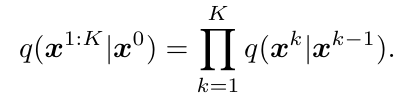
* The equation describes a forward diffusion process applied to a sample x0 drawn from a real data distribution q(x)
* q(x^{1:K|x^0}): this represents the probability distribution of the sequence of noisy samples given the initial sample x0

* second part: this is the product of ocnditional probabilities of each noisy sample x^k given the previous sample x^(k-1). it indicates that the noisy samples are generated step-by-step in a Markov chain, where each step depends only on the previous step. 

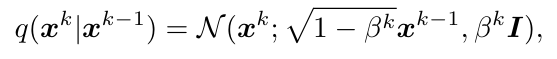
* the foward diffusion process gradually adds gaussian noise to the sample in  steps. the noise added at each step is controlled by a variance schedule

* The noisy sample x^k is drawn from a normal distribution centered around $\sqrt{1-\beta_k}x^{k-1}$ with variance $\beta_k$


### Diffusion Process and Sample Generation

When $K \to \infty$, the noisy sample $x^K$ approaches an isotropic Gaussian distribution. This means that as the number of steps $K$ increases, the final noisy sample $ x^K $ becomes a sample from a standard normal distribution.

### Learning and Reversing the Diffusion Process

Diffusion models learn a conditional distribution $p_\theta(x^{k-1}|x^k) $ to generate new samples by reversing the diffusion process. The reverse process is described by:

$$ p_\theta(x^{0:K}) = p(x^K) \prod_{k=1}^K p_\theta(x^{k-1}|x^k) $$

This equation represents the probability distribution of the sequence of samples $ x^{0:K} $ generated by the reverse process. Here:

- **$ p(x^K) $**: This is the initial distribution of the final noisy sample $ x^K $, which is a standard normal distribution $ \mathcal{N}(0, I) $.

- **$ \prod_{k=1}^K p_\theta(x^{k-1}|x^k) $**: This is the product of the learned conditional probabilities for each step in the reverse process.

### Conditional Distribution in the Reverse Process

The conditional distribution $ p_\theta(x^{k-1}|x^k) $ is modeled as a normal distribution:

$$ p_\theta(x^{k-1}|x^k) = \mathcal{N}(x^{k-1}; \mu_\theta(x^k, k), \Sigma_\theta(x^k, k)) $$

Here:

- **$ \mu_\theta(x^k, k) $**: This is the mean of the normal distribution, which is a function of the noisy sample $ x^k $ and the timestep $ k $.

- **$ \Sigma_\theta(x^k, k) $**: This is the covariance matrix of the normal distribution, also a function of $( x^k )$ and $( k )$.

### Training Objective

The training of the diffusion model is performed by maximizing the evidence lower bound (ELBO):

$$ \mathbb{E}_{q_0}[ \log p_{\theta}(x^{0:K}) ] = \mathbb{E}_{q} \left[ \log \frac{p_{\theta}(x^{0:K})}{q(x^{1:K}|x_0)} \right] $$

This objective aims to maximize the likelihood of the generated samples $x^{0:K}$ under the learned model $ p_\theta$, compared to the true distribution $ q $.

In summary, this part explains how diffusion models generate new samples by reversing the diffusion process and how they are trained to maximize the likelihood of the generated samples.


## 0. nets.py

In [ ]:
from functools import partial
from typing import Tuple
import distrax
import flax.linen as nn
import jax
import jax.numpy as jnp

from diffusion.diffusion import(
    GaussianDiffusion,
    ModelMeanType,
    _extract_into_tensor,
)

from diffusion.dpm_solver import DPM_Solver, NoiseScheduleVP
from utilities.jax_utils import extend_and_repeat 

def multiple_action_q_function(forward):
    def wrapped(self, observations, actions, **kwargs):
        multiple_actions = False
        batch_size = observations.shape[0]
        if actions.ndim == 3 and observations.ndim == 2:
            multiple_actions = True
            observations = extend_and_repeat(observations, 1, actions.shape[1])
            observations = observations.reshape(-1, observations.shape[-1])
            actions = actions.reshape(-1, actions.shape[-1])
        q_values = forward(self, observations, actions, **kwargs)
        if multiple_actions:
            q_values = q_values.reshape(batch_size, -1)
        return q_values
    return wrapped

def mish(x):
    return x * jax.nn.tanh(jax.nn.softplus(x))

def sinusoidal_embedding(timesteps, dim, max_period=10000):
    """ 
    Create sinusoidal embeddings for the timesteps.
    
    :param timesteps: The timesteps to embed., 1D tensor of shape (batch_size,).
    :param dim: The dimension of the embedding.
    :param max_period: The maximum period for the sine and cosine functions. or minimum frequency.
    :return: an [N x dim] Tensor of positional embeddings
    """
    half = dim // 2
    freqs = jnp.exp(
        -jnp.log(max_period) * jnp.arange(half, dtype=jnp.float32) / half
    )

    # args = timesteps[:, None] * freqs[None, :]
    args = jnp.expand_dims(timesteps, axis=-1) * freqs[None, :]
    embd = jnp.concatenate([jnp.cos(args), jnp.sin(args)], axis=-1)
    return embd


class TimeEmbedding(nn.Module):
    embed_size: int
    act: callable = mish

    @nn.compact
    def __call__(self, timesteps):
        x = sinusoidal_embedding(timesteps, self.embed_size)
        x = nn.Dense(self.embed_size * 2)(x)
        x = self.act(x)
        x = nn.Dense(self.embed_size)(x)
        return x
    
class PolicyNet(nn.Module):
    output_dim: int
    arch: Tuple = (256, 256, 256)
    time_embed_size: int = 16
    act: callable = mish
    use_layer_norm: bool = False

    @nn.compact
    def __call__(self, state, action, t):
        time_embed = TimeEmbedding(self.time_embed_size, self.act)(t)
        x = jnp.concatenate([state, action, time_embed], axis=-1)

        for feat in self.arch:
            x = nn.Dense(feat)(x)
            if self.use_layer_norm:
                x = nn.LayerNorm()(x)
            x = self.act(x)

        x = nn.Dense(self.output_dim)(x)
        return x

class DiffusionPolicy(nn.Module):
    diffusion: GaussianDiffusion
    observation_dim: int
    action_dim: int
    arch: Tuple = (256, 256, 256)
    time_embed_size: int = 16
    act: callable = mish
    use_layer_norm: bool = False
    use_dpm: bool = False
    sample_method: str = 'ddpm'
    dpm_steps: int = 15
    dpm_t_end: float = 0.001

    def setup(self):
        self.base_net = PolicyNet(
            output_dim=self.action_dim,
            arch=self.arch,
            time_embed_size=self.time_embed_size,
            act=self.act,
            use_layer_norm=self.use_layer_norm,
        )
    
    def __call__(self, rng, observations, deterministic=False, reapt=None):
        return getattr(self, f"{self.sample_method}_sample")(rng, observations, deterministic, reapt)
    
    def ddpm_sample(self, rng, observations, deterministic=False, repeat=None):
        if repeat is not None:
            observations = extend_and_repeat(observations, 1, repeat)
        
        shape = observations.shape[:-1] + (self.action_dim,)

        return self.diffusion.p_sample_loop(
            rng_key=rng,
            model_forward=partial(self.base_net, observations),
            shape=shape,
            clip_denoised=True,
        )
    

    def dpm_sample(self, rng, observations, deterministic=False, repeat=None):
        if repeat is not None:
            observations = extend_and_repeat(observations, 1, repeat)
        noise_clip = True

        shape = observations.shape[:-1] + (self.action_dim,)

        ns = NoiseScheduleVP(
            schedule='discrete', alphas_cumrpod=self.diffusion.alphas_cumprod
        )

        def wrap_model(model_fn):
            def wrapped_mode_fn(x, t):
                t = (t - 1. / ns.total_N) * ns.total_N
                out = model_fn(x, t)
                # add noise clipping
                if noise_clip:
                    t = t.astype(jnp.int32)
                    x_w = _extract_into_tensor(
                        self.diffusion.sqrt_recipm1_alphas_cumprod, t, x.shape
                    )
                    max_value = (self.diffusion.max_value + x_w * x) / e_w
                    min_value = (self.diffusion.min_value + x_w * x) / e_w

                    out = out.clip(min_value, max_value)
                return out
            return wrapped_mode_fn
        
        dpm_sampler = DPM_Solver(
            model_fn = wrap_model(partial(self.base_net, observations)),
            noise_schedule=ns,
            predict_x0 = self.diffusion.model_mean_type is ModelMeanType.START_X0,
        )
        x = jax.random.normal(rng, shape)
        out = dpm_sampler.sample(x, steps=self.dpm_steps, t_end=self.dpm_t_end)
        return out
    
    def ddim_sample(self, rng, observations, deterministic=False, repeat=None):
        if repeat is not None:
            observations = extend_and_repeat(observations, 1, repeat)

        shape = observations.shape[:-1] + (self.action_dim,)

        return self.diffusion.ddim_sample(
            rng_key=rng,
            model_forward=partial(self.base_net, observations),
            shape=shape,
            clip_denoised=True,
        )
    
    def forward(self, observations, actions, t):
        return self.base_net(observations, actions, t)
    
    def loss(self, rng_key, observations, actions, ts):
        terms = self.diffusion.training_losses(
            rng_key,
            model_forward=partial(self.base_net, observations),
            x_start=actions,
            t=ts
        )
        return terms
        noise = jax.random.normal(rng_key, actions.shape, dtype=actions.dtype)
        out = self.base_net(observations, noise, ts*0)
        return {'loss': jnp.square(out - actions)}
    
    @property
    def max_action(self):
        return self.diffusion.max_value
    
class Critic(nn.Module):
    observation_dim: int
    action_dim: int
    arch: Tuple = (256, 256, 256)
    act: callable = mish
    use_layer_norm: bool = False
    orthogonal_init: bool = False

    @nn.compact
    @multiple_action_q_function
    def __call__(self, observations, actions):
        x = jnp.concatenate([observations, actions], axis=-1)

        for feat in self.arch:
            if self.orthogonal_init:
                x = nn.Dense(
                    feat,
                    kernel_init=jax.initializers.orthogonal(jnp.sqrt(2.0)),
                    bias_init=jax.nn.initializers.zeros,
                )(x)
            else:
                x = nn.Dense(feat)(x)
            if self.use_layer_norm:
                x = nn.LayerNorm()(x)
            x = self.act(x)
        
            if self.orthogonal_init:
                x = nn.Dense(
                    1,
                    kernel_init=jax.nn.initializers.orthogonal(jnp.sqrt(2.0)),
                    bias_init=jax.nn.initializers.zeros,
                )(x)
            else:
                x = nn.Dense(1)(x)
            return jnp.squeeze(x, -1)
    @property
    def input_size(self):
        return self.observation_dim + self.action_dim
    
class GaussianPolicy(nn.Module):
    action_dim: int
    log_std_min: float = -5.0
    log_std_max: float = 2.0
    temperature: float = 1.0

    @nn.compact
    def __call__(self, mean):
        log_std = self.param(
            'log_stds', nn.initializers.zeros, (self.action_dim,)
        )
        log_std = jnp.clip(log_std, self.log_std_min, self.log_std_max)
        return distrax.MultivariateNormalDiag(
            loc=mean, scale=jnp.exp(log_std) * self.temperature
        )


class Value(nn.Module):
    observation_dim: int
    arch: Tuple = (256, 256, 256)
    act: callable = mish
    use_layer_norm: bool = False
    orthogonal_init: bool = False

    @nn.compact
    def __call__(self, observations):
        x = observations

        for feat in self.arch:
        if self.orthogonal_init:
            x = nn.Dense(
            feat,
            kernel_init=jax.nn.initializers.orthogonal(jnp.sqrt(2.0)),
            bias_init=jax.nn.initializers.zeros,
            )(
            x
            )
        else:
            x = nn.Dense(feat)(x)
        if self.use_layer_norm:
            x = nn.LayerNorm()(x)
        x = self.act(x)

        if self.orthogonal_init:
        x = nn.Dense(
            1,
            kernel_init=jax.nn.initializers.orthogonal(jnp.sqrt(2.0)),
            bias_init=jax.nn.initializers.zeros,
        )(
            x
        )
        else:
        x = nn.Dense(1)(x)
        return jnp.squeeze(x, -1)

    @property
    def input_size(self):
        return self.observation_dim

# 1. Diffusion.py

In [ ]:

import enum
import math

# import numpy as np
import jax
import jax.numpy as np


def mean_flat(tensor):
  """
  Take the mean over all non-batch dimensions.
  """
  return tensor.mean(axis=list(range(1, len(tensor.shape))))


def get_named_beta_schedule(schedule_name, num_diffusion_timesteps):
  """
  Get a pre-defined beta schedule for the given name.

  The beta schedule library consists of beta schedules which remain similar
  in the limit of num_diffusion_timesteps.
  Beta schedules may be added, but should not be removed or changed once
  they are committed to maintain backwards compatibility.
  """
  if schedule_name == "linear":
    # Linear schedule from Ho et al, extended to work for any number of
    # diffusion steps.
    # NOTE: Double check beta start and end
    scale = 1000 / num_diffusion_timesteps
    # scale = 1.0
    beta_start = scale * 0.0001
    beta_end = scale * 0.02
    return np.linspace(
      beta_start, beta_end, num_diffusion_timesteps, dtype=np.float64
    )
  elif schedule_name == "cosine":
    return betas_for_alpha_bar(
      num_diffusion_timesteps,
      lambda t: math.cos((t + 0.008) / 1.008 * math.pi / 2)**2,
    )
  elif schedule_name == "vp":
    T = num_diffusion_timesteps
    t = np.arange(1, T + 1)
    b_max = 10.
    b_min = 0.1
    alpha = np.exp(-b_min / T - 0.5 * (b_max - b_min) * (2 * t - 1) / T**2)
    betas = 1 - alpha
    return betas
  else:
    raise NotImplementedError(f"unknown beta schedule: {schedule_name}")


def betas_for_alpha_bar(num_diffusion_timesteps, alpha_bar, max_beta=0.999):
  """
  Create a beta schedule that discretizes the given alpha_t_bar function,
  which defines the cumulative product of (1-beta) over time from t = [0,1].

  :param num_diffusion_timesteps: the number of betas to produce.
  :param alpha_bar: a lambda that takes an argument t from 0 to 1 and
                    produces the cumulative product of (1-beta) up to that
                    part of the diffusion process.
  :param max_beta: the maximum beta to use; use values lower than 1 to
                   prevent singularities.
  """
  betas = []
  for i in range(num_diffusion_timesteps):
    t1 = i / num_diffusion_timesteps
    t2 = (i + 1) / num_diffusion_timesteps
    betas.append(min(1 - alpha_bar(t2) / alpha_bar(t1), max_beta))
  return np.array(betas)


class ModelMeanType(enum.Enum):
  """
  Which type of output the model predicts.
  """

  PREVIOUS_X = enum.auto()  # the model predicts x_{t-1}
  START_X = enum.auto()  # the model predicts x_0
  EPSILON = enum.auto()  # the model predicts epsilon


class ModelVarType(enum.Enum):
  """
  What is used as the model's output variance.

  The LEARNED_RANGE option has been added to allow the model to predict
  values between FIXED_SMALL and FIXED_LARGE, making its job easier.
  """

  LEARNED = enum.auto()
  FIXED_SMALL = enum.auto()
  FIXED_LARGE = enum.auto()
  LEARNED_RANGE = enum.auto()


class LossType(enum.Enum):
  MSE = enum.auto()  # use raw MSE loss (and KL when learning variances)
  RESCALED_MSE = (
    enum.auto()
  )  # use raw MSE loss (with RESCALED_KL when learning variances)
  KL = enum.auto()  # use the variational lower-bound
  RESCALED_KL = enum.auto()  # like KL, but rescale to estimate the full VLB

  def is_vb(self):
    return self == LossType.KL or self == LossType.RESCALED_KL


class GaussianDiffusion:
  """
  Utilities for training and sampling diffusion models.

  Ported directly from here, and adapted over time to further experimentation.
  https://github.com/hojonathanho/diffusion/blob/1e0dceb3b3495bbe19116a5e1b3596cd0706c543/diffusion_tf/diffusion_utils_2.py#L42

  :param betas: a 1-D numpy array of betas for each diffusion timestep,
                starting at T and going to 1.
  :param model_mean_type: a ModelMeanType determining what the model outputs.
  :param model_var_type: a ModelVarType determining how variance is output.
  :param loss_type: a LossType determining the loss function to use.
  :param rescale_timesteps: if True, pass floating point timesteps into the
                            model so that they are always scaled like in the
                            original paper (0 to 1000).
  """

  def __init__(
    self,
    *,
    num_timesteps,
    schedule_name,
    model_mean_type,
    model_var_type,
    loss_type,
    min_value=-1.,
    max_value=1.,
    rescale_timesteps=False,
  ):
    self.schedule_name = schedule_name
    self.model_mean_type = model_mean_type
    self.model_var_type = model_var_type
    self.loss_type = loss_type
    self.rescale_timesteps = rescale_timesteps
    self.min_value = min_value
    self.max_value = max_value

    # Use float64 for accuracy.
    betas = get_named_beta_schedule(schedule_name, num_timesteps)
    # betas = np.array(betas, dtype=np.float64)
    betas = np.array(betas, dtype=np.float32)
    self.betas = betas
    assert len(betas.shape) == 1, "betas must be 1-D"
    assert (betas > 0).all() and (betas <= 1).all()

    self.num_timesteps = int(betas.shape[0])

    alphas = 1.0 - betas
    self.alphas_cumprod = np.cumprod(alphas, axis=0)
    self.alphas_cumprod_prev = np.append(1.0, self.alphas_cumprod[:-1])
    self.alphas_cumprod_next = np.append(self.alphas_cumprod[1:], 0.0)
    assert self.alphas_cumprod_prev.shape == (self.num_timesteps,)

    # calculations for diffusion q(x_t | x_{t-1}) and others
    self.sqrt_alphas_cumprod = np.sqrt(self.alphas_cumprod)
    self.sqrt_one_minus_alphas_cumprod = np.sqrt(1.0 - self.alphas_cumprod)
    self.log_one_minus_alphas_cumprod = np.log(1.0 - self.alphas_cumprod)
    self.sqrt_recip_alphas_cumprod = np.sqrt(1.0 / self.alphas_cumprod)
    self.sqrt_recipm1_alphas_cumprod = np.sqrt(1.0 / self.alphas_cumprod - 1)

    # calculations for posterior q(x_{t-1} | x_t, x_0)
    self.posterior_variance = (
      betas * (1.0 - self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)
    )
    # log calculation clipped because the posterior variance is 0 at the
    # beginning of the diffusion chain.
    self.posterior_log_variance_clipped = np.log(
      np.append(self.posterior_variance[1], self.posterior_variance[1:])
    )
    self.posterior_mean_coef1 = (
      betas * np.sqrt(self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)
    )
    self.posterior_mean_coef2 = (
      (1.0 - self.alphas_cumprod_prev) * np.sqrt(alphas) /
      (1.0 - self.alphas_cumprod)
    )
    self.ts_weights = ws = betas / (2 * (1 - self.alphas_cumprod) * alphas)
    self.normalized_ts_weights = ws * num_timesteps / ws.sum()

  def q_mean_variance(self, x_start, t):
    """
    Get the distribution q(x_t | x_0).

    :param x_start: the [N x C x ...] tensor of noiseless inputs.
    :param t: the number of diffusion steps (minus 1). Here, 0 means one step.
    :return: A tuple (mean, variance, log_variance), all of x_start's shape.
    """
    mean = (
      _extract_into_tensor(self.sqrt_alphas_cumprod, t, x_start.shape) *
      x_start
    )
    variance = _extract_into_tensor(
      1.0 - self.alphas_cumprod, t, x_start.shape
    )
    log_variance = _extract_into_tensor(
      self.log_one_minus_alphas_cumprod, t, x_start.shape
    )
    return mean, variance, log_variance

  def q_sample(self, x_start, t, noise):
    """
    Diffuse the data for a given number of diffusion steps.

    In other words, sample from q(x_t | x_0).

    :param x_start: the initial data batch.
    :param t: the number of diffusion steps (minus 1). Here, 0 means one step.
    :param noise: the split-out normal noise.
    :return: A noisy version of x_start.
    """
    assert noise.shape == x_start.shape
    return (
      _extract_into_tensor(self.sqrt_alphas_cumprod, t, x_start.shape) *
      x_start + _extract_into_tensor(
        self.sqrt_one_minus_alphas_cumprod, t, x_start.shape
      ) * noise
    )

  def q_posterior_mean_variance(self, x_start, x_t, t):
    """
    Compute the mean and variance of the diffusion posterior:

        q(x_{t-1} | x_t, x_0)

    """
    assert x_start.shape == x_t.shape
    posterior_mean = (
      _extract_into_tensor(self.posterior_mean_coef1, t, x_t.shape) * x_start +
      _extract_into_tensor(self.posterior_mean_coef2, t, x_t.shape) * x_t
    )
    posterior_variance = _extract_into_tensor(
      self.posterior_variance, t, x_t.shape
    )
    posterior_log_variance_clipped = _extract_into_tensor(
      self.posterior_log_variance_clipped, t, x_t.shape
    )
    assert (
      posterior_mean.shape[0] == posterior_variance.shape[0] ==
      posterior_log_variance_clipped.shape[0] == x_start.shape[0]
    )
    return posterior_mean, posterior_variance, posterior_log_variance_clipped

  def p_mean_variance(self, model_output, x, t, clip_denoised=True):
    """
    Apply the model to get p(x_{t-1} | x_t), as well as a prediction of
    the initial x, x_0.

    :param model_output: the model prediction, which takes a signal and a
                         batch of timesteps as input.
    :param x: the [N x C x ...] tensor at time t.
    :param t: a 1-D Tensor of timesteps.
    :param clip_denoised: if True, clip the denoised signal into [-1, 1].
    :return: a dict with the following keys:
             - 'mean': the model mean output.
             - 'variance': the model variance output.
             - 'log_variance': the log of 'variance'.
             - 'pred_xstart': the prediction for x_0.
    """
    B, C = x.shape[:2]

    if self.model_var_type in [
      ModelVarType.LEARNED, ModelVarType.LEARNED_RANGE
    ]:
      assert model_output.shape == (B, C * 2, *x.shape[2:])
      model_output, model_var_values = np.split(model_output, C, axis=1)
      if self.model_var_type == ModelVarType.LEARNED:
        model_log_variance = model_var_values
        model_variance = np.exp(model_log_variance)
      else:
        min_log = _extract_into_tensor(
          self.posterior_log_variance_clipped, t, x.shape
        )
        max_log = _extract_into_tensor(np.log(self.betas), t, x.shape)
        # The model_var_values is [-1, 1] for [min_var, max_var].
        frac = (model_var_values + 1) / 2
        model_log_variance = frac * max_log + (1 - frac) * min_log
        model_variance = np.exp(model_log_variance)
    else:
      model_variance, model_log_variance = {
        # for fixedlarge, we set the initial (log-)variance like so
        # to get a better decoder log likelihood.
        ModelVarType.FIXED_LARGE:
          (
            np.append(self.posterior_variance[1], self.betas[1:]),
            np.log(np.append(self.posterior_variance[1], self.betas[1:])),
          ),
        ModelVarType.FIXED_SMALL:
          (
            self.posterior_variance,
            self.posterior_log_variance_clipped,
          ),
      }[self.model_var_type]
      model_variance = _extract_into_tensor(model_variance, t, x.shape)
      model_log_variance = _extract_into_tensor(model_log_variance, t, x.shape)

    def process_xstart(x):
      if clip_denoised:
        return x.clip(self.min_value, self.max_value)
      return x

    if self.model_mean_type == ModelMeanType.PREVIOUS_X:
      pred_xstart = process_xstart(
        self._predict_xstart_from_xprev(x_t=x, t=t, xprev=model_output)
      )
      model_mean = model_output
    elif self.model_mean_type in [
      ModelMeanType.START_X, ModelMeanType.EPSILON
    ]:
      if self.model_mean_type == ModelMeanType.START_X:
        pred_xstart = process_xstart(model_output)
      else:
        pred_xstart = process_xstart(
          self._predict_xstart_from_eps(x_t=x, t=t, eps=model_output)
        )
      model_mean, _, _ = self.q_posterior_mean_variance(
        x_start=pred_xstart, x_t=x, t=t
      )
    else:
      raise NotImplementedError(self.model_mean_type)

    assert (
      model_mean.shape == model_log_variance.shape == pred_xstart.shape ==
      x.shape
    )
    return {
      "mean": model_mean,
      "variance": model_variance,
      "log_variance": model_log_variance,
      "pred_xstart": pred_xstart,
    }

  def p_mean_variance_(self, model_output, x, t, clip_denoised=True):

    def process_xstart(x):
      if clip_denoised:
        return x.clip(self.min_value, self.max_value)
      return x

    if self.model_mean_type == ModelMeanType.START_X:
      pred_xstart = process_xstart(model_output)
    elif self.model_mean_type == ModelMeanType.EPSILON:
      pred_xstart = process_xstart(
        self._predict_xstart_from_eps(x_t=x, t=t, eps=model_output)
      )

    posterior_mean, posterior_variance, posterior_log_variance = \
      self.q_posterior_mean_variance(x_start=pred_xstart, x_t=x, t=t)
    return {
      "mean": posterior_mean,
      "variance": posterior_variance,
      "log_variance": posterior_log_variance,
      "pred_xstart": pred_xstart,
    }

  def _predict_xstart_from_eps(self, x_t, t, eps):
    assert x_t.shape == eps.shape
    return (
      _extract_into_tensor(self.sqrt_recip_alphas_cumprod, t, x_t.shape) * x_t
      - _extract_into_tensor(self.sqrt_recipm1_alphas_cumprod, t, x_t.shape) *
      eps
    )

  def _predict_xstart_from_xprev(self, x_t, t, xprev):
    assert x_t.shape == xprev.shape
    return (  # (xprev - coef2*x_t) / coef1
        _extract_into_tensor(
            1.0 / self.posterior_mean_coef1, t, x_t.shape) * xprev
        - _extract_into_tensor(
            self.posterior_mean_coef2 / self.posterior_mean_coef1, t, x_t.shape
        )
        * x_t
    )

  def _predict_eps_from_xstart(self, x_t, t, pred_xstart):
    return (
      _extract_into_tensor(self.sqrt_recip_alphas_cumprod, t, x_t.shape) * x_t
      - pred_xstart
    ) / _extract_into_tensor(self.sqrt_recipm1_alphas_cumprod, t, x_t.shape)

  def _scale_timesteps(self, t):
    if self.rescale_timesteps:
      return t.float() * (1000.0 / self.num_timesteps)
    return t

  def condition_mean(self, cond_fn, p_mean_var, x, t, model_kwargs=None):
    """
    Compute the mean for the previous step, given a function cond_fn that
    computes the gradient of a conditional log probability with respect to
    x. In particular, cond_fn computes grad(log(p(y|x))), and we want to
    condition on y.

    This uses the conditioning strategy from Sohl-Dickstein et al. (2015).
    """
    gradient = cond_fn(x, self._scale_timesteps(t), **model_kwargs)
    new_mean = (
      p_mean_var["mean"].float() + p_mean_var["variance"] * gradient.float()
    )
    return new_mean

  def condition_score(self, cond_fn, p_mean_var, x, t, model_kwargs=None):
    """
    Compute what the p_mean_variance output would have been, should the
    model's score function be conditioned by cond_fn.

    See condition_mean() for details on cond_fn.

    Unlike condition_mean(), this instead uses the conditioning strategy
    from Song et al (2020).
    """
    alpha_bar = _extract_into_tensor(self.alphas_cumprod, t, x.shape)

    eps = self._predict_eps_from_xstart(x, t, p_mean_var["pred_xstart"])
    eps = eps - (1 - alpha_bar).sqrt(
    ) * cond_fn(x, self._scale_timesteps(t), **model_kwargs)

    out = p_mean_var.copy()
    out["pred_xstart"] = self._predict_xstart_from_eps(x, t, eps)
    out["mean"], _, _ = self.q_posterior_mean_variance(
      x_start=out["pred_xstart"], x_t=x, t=t
    )
    return out

  def p_sample(
    self,
    rng,
    model_output,
    x,
    t,
    clip_denoised=True,
    cond_fn=None,
    model_kwargs=None,
  ):
    """
    Sample x_{t-1} from the model at the given timestep.

    :param rng: RNGKey for random sampling.
    :param model_output: the model prediction to sample from.
    :param x: the current tensor at x_{t-1}.
    :param t: the value of t, starting at 0 for the first diffusion step.
    :param clip_denoised: if True, clip the x_start prediction to [-1, 1].
    :param denoised_fn: if not None, a function which applies to the
        x_start prediction before it is used to sample.
    :param cond_fn: if not None, this is a gradient function that acts
                    similarly to the model.
    :param model_kwargs: if not None, a dict of extra keyword arguments to
        pass to the model. This can be used for conditioning.
    :return: a dict containing the following keys:
             - 'sample': a random sample from the model.
             - 'pred_xstart': a prediction of x_0.
    """
    out = self.p_mean_variance(model_output, x, t, clip_denoised=clip_denoised)
    noise = jax.random.normal(rng, x.shape, dtype=x.dtype)

    # nonzero_mask = (
    #   (t != 0).float().view(-1, *([1] * (len(x.shape) - 1)))
    # )  # no noise when t == 0
    # nonzero_mask = (
    #   (t != 0).astype(np.float32).reshape((-1, *([1] * (len(x.shape) - 1))))
    # )
    nonzero_mask = np.expand_dims((t != 0).astype(np.float32), axis=-1)
    if cond_fn is not None:
      out["mean"] = self.condition_mean(
        cond_fn, out, x, t, model_kwargs=model_kwargs
      )
    sample = out["mean"] + \
      nonzero_mask * np.exp(0.5 * out["log_variance"]) * noise
    return {"sample": sample, "pred_xstart": out["pred_xstart"]}

  def p_sample_loop(
    self,
    rng_key,
    model_forward,
    shape,
    clip_denoised=True,
    cond_fn=None,
    model_kwargs=None,
  ):
    """
    Generate samples from the model.

    :param model_forward: the model apply function without passing params.
    :param shape: the shape of the samples, (N, C, H, W).
    :param noise: if specified, the noise from the encoder to sample.
                  Should be of the same shape as `shape`.
    :param clip_denoised: if True, clip x_start predictions to [-1, 1].
    :param denoised_fn: if not None, a function which applies to the
        x_start prediction before it is used to sample.
    :param cond_fn: if not None, this is a gradient function that acts
                    similarly to the model.
    :param model_kwargs: if not None, a dict of extra keyword arguments to
        pass to the model. This can be used for conditioning.
    :return: a non-differentiable batch of samples.
    """
    rng_key, sample_key = jax.random.split(rng_key)
    x = jax.random.normal(sample_key, shape)

    indices = list(range(self.num_timesteps))[::-1]
    for i in indices:
      t = np.ones(shape[:-1], dtype=np.int32) * i
      model_output = model_forward(x, self._scale_timesteps(t))
      rng_key, sample_key = jax.random.split(rng_key)
      out = self.p_sample(
        sample_key, model_output, x, t, clip_denoised, cond_fn, model_kwargs
      )
      x = out["sample"]
    return x

  def ddim_sample(
    self,
    rng_key,
    model_putput,
    x,
    t,
    clip_denoised=True,
    cond_fn=None,
    model_kwargs=None,
    eta=0.0,
  ):
    """
    Sample x_{t-1} from the model using DDIM.

    Same usage as p_sample().
    """
    out = self.p_mean_variance(model_putput, x, t, clip_denoised=clip_denoised)
    if cond_fn is not None:
      out = self.condition_score(cond_fn, out, x, t, model_kwargs=model_kwargs)

    # Usually our model outputs epsilon, but we re-derive it
    # in case we used x_start or x_prev prediction.
    eps = self._predict_eps_from_xstart(x, t, out["pred_xstart"])

    alpha_bar = _extract_into_tensor(self.alphas_cumprod, t, x.shape)
    alpha_bar_prev = _extract_into_tensor(self.alphas_cumprod_prev, t, x.shape)
    sigma = (
      eta * np.sqrt((1 - alpha_bar_prev) / (1 - alpha_bar)) *
      np.sqrt(1 - alpha_bar / alpha_bar_prev)
    )
    # Equation 12.
    noise = jax.random.normal(rng_key, x.shape, dtype=x.dtype)
    mean_pred = (
      out["pred_xstart"] * np.sqrt(alpha_bar_prev) +
      np.sqrt(1 - alpha_bar_prev - sigma**2) * eps
    )
    # nonzero_mask = (
    #   (t != 0).float().view(-1, *([1] * (len(x.shape) - 1)))
    # )  # no noise when t == 0
    nonzero_mask = np.expand_dims((t != 0).astype(np.float32), axis=-1)
    sample = mean_pred + nonzero_mask * sigma * noise
    return {"sample": sample, "pred_xstart": out["pred_xstart"]}

  def ddim_reverse_sample(
    self,
    model_putput,
    x,
    t,
    clip_denoised=True,
    eta=0.0,
  ):
    """
    Sample x_{t+1} from the model using DDIM reverse ODE.
    """
    assert eta == 0.0, "Reverse ODE only for deterministic path"
    out = self.p_mean_variance(model_putput, x, t, clip_denoised=clip_denoised)
    # Usually our model outputs epsilon, but we re-derive it
    # in case we used x_start or x_prev prediction.
    eps = (
      _extract_into_tensor(self.sqrt_recip_alphas_cumprod, t, x.shape) * x -
      out["pred_xstart"]
    ) / _extract_into_tensor(self.sqrt_recipm1_alphas_cumprod, t, x.shape)
    alpha_bar_next = _extract_into_tensor(self.alphas_cumprod_next, t, x.shape)

    # Equation 12. reversed
    mean_pred = (
      out["pred_xstart"] * np.sqrt(alpha_bar_next) +
      np.sqrt(1 - alpha_bar_next) * eps
    )

    return {"sample": mean_pred, "pred_xstart": out["pred_xstart"]}

  def ddim_sample_loop(
    self,
    rng_key,
    model_forward,
    shape,
    clip_denoised=True,
    cond_fn=None,
    model_kwargs=None,
    eta=0.0,
  ):
    """
    Generate samples from the model using DDIM.

    Same usage as p_sample_loop().
    """
    rng_key, sample_key = jax.random.split(rng_key)
    x = jax.random.normal(sample_key, shape)

    indices = list(range(self.num_timesteps))[::-1]
    for i in indices:
      t = np.ones(shape[:-1], dtype=np.int32) * i
      model_ouput = model_forward(x, self._scale_timesteps(t))
      rng_key, sample_key = jax.random.split(rng_key)
      out = self.ddim_sample(
        sample_key, model_ouput, x, t, clip_denoised, cond_fn, model_kwargs,
        eta
      )
      x = out["sample"]
    return x

  def _vb_terms_bpd(self, model_ouput, x_start, x_t, t, clip_denoised=True):
    """
    Get a term for the variational lower-bound.

    The resulting units are bits (rather than nats, as one might expect).
    This allows for comparison to other papers.

    :return: a dict with the following keys:
             - 'output': a shape [N] tensor of NLLs or KLs.
             - 'pred_xstart': the x_0 predictions.
    """
    true_mean, _, true_log_variance_clipped = self.q_posterior_mean_variance(
      x_start=x_start, x_t=x_t, t=t
    )
    out = self.p_mean_variance(model_ouput, x_t, t, clip_denoised)
    kl = normal_kl(
      true_mean, true_log_variance_clipped, out["mean"], out["log_variance"]
    )
    kl = mean_flat(kl) / np.log(2.0)

    decoder_nll = -discretized_gaussian_log_likelihood(
      x_start, means=out["mean"], log_scales=0.5 * out["log_variance"]
    )
    assert decoder_nll.shape == x_start.shape
    decoder_nll = mean_flat(decoder_nll) / np.log(2.0)

    # At the first timestep return the decoder NLL,
    # otherwise return KL(q(x_{t-1}|x_t,x_0) || p(x_{t-1}|x_t))
    output = np.where((t == 0), decoder_nll, kl)
    return {"output": output, "pred_xstart": out["pred_xstart"]}

  def training_losses(self, rng_key, model_forward, x_start, t):
    """
    Compute training losses for a single timestep.

    :param model: the model to evaluate loss on.
    :param x_start: the [N x C x ...] tensor of inputs.
    :param t: a batch of timestep indices.
    :param model_kwargs: if not None, a dict of extra keyword arguments to
        pass to the model. This can be used for conditioning.
    :return: a dict with the key "loss" containing a tensor of shape [N].
             Some mean or variance settings may also have other keys.
    """
    noise = jax.random.normal(rng_key, x_start.shape, dtype=x_start.dtype)
    x_t = self.q_sample(x_start, t, noise=noise)
    model_output = model_forward(x_t, self._scale_timesteps(t))

    terms = {"model_output": model_output, "x_t": x_t}
    terms["ts_weights"] = _extract_into_tensor(
      self.normalized_ts_weights, t, x_start.shape[:-1]
    )

    if self.loss_type == LossType.KL or self.loss_type == LossType.RESCALED_KL:
      terms["loss"] = self._vb_terms_bpd(
        model_output, x_start=x_start, x_t=x_t, t=t, clip_denoised=False
      )["output"]
      if self.loss_type == LossType.RESCALED_KL:
        terms["loss"] *= self.num_timesteps
    elif self.loss_type in (LossType.MSE, LossType.RESCALED_MSE):
      if self.model_var_type in (
        ModelVarType.LEARNED, ModelVarType.LEARNED_RANGE
      ):
        B, C = x_t.shape[:2]
        assert model_output.shape == (B, C * 2, *x_t.shape[2:])
        model_output, model_var_values = np.split(model_output, C, axis=1)
        # Learn the variance using the variational bound, but don't let
        # it affect our mean prediction.
        frozen_out = np.concatenate(
          [model_output.detach(), model_var_values], axis=1
        )
        terms["vb"] = self._vb_terms_bpd(
          frozen_out, x_start=x_start, x_t=x_t, t=t, clip_denoised=False
        )["output"]
        if self.loss_type == LossType.RESCALED_MSE:
          # Divide by 1000 for equivalence with initial implementation.
          # Without a factor of 1/1000, the VB term hurts the MSE term.
          terms["vb"] *= self.num_timesteps / 1000.0

      target = {
        ModelMeanType.PREVIOUS_X:
          self.q_posterior_mean_variance(x_start=x_start, x_t=x_t, t=t)[0],
        ModelMeanType.START_X:
          x_start,
        ModelMeanType.EPSILON:
          noise,
      }[self.model_mean_type]
      assert model_output.shape == target.shape == x_start.shape
      terms["mse"] = mean_flat((target - model_output)**2)
      # terms["mse"] = (target - model_output)**2
      if "vb" in terms:
        terms["loss"] = terms["mse"] + terms["vb"]
      else:
        terms["loss"] = terms["mse"]
    else:
      raise NotImplementedError(self.loss_type)

    return terms

  def training_losses_(self, rng_key, model_forward, x_start, t):
    noise = jax.random.normal(rng_key, x_start.shape, dtype=x_start.dtype)
    x_t = self.q_sample(x_start, t, noise=noise)

    model_output = model_forward(x_t, self._scale_timesteps(t))

    target = {
      ModelMeanType.START_X: x_start,
      ModelMeanType.EPSILON: noise,
    }[self.model_mean_type]
    mse = np.square(target - model_output)
    return {"loss": mse, "model_output": model_output}

  def _prior_bpd(self, x_start):
    """
    Get the prior KL term for the variational lower-bound, measured in
    bits-per-dim.

    This term can't be optimized, as it only depends on the encoder.

    :param x_start: the [N x C x ...] tensor of inputs.
    :return: a batch of [N] KL values (in bits), one per batch element.
    """
    batch_size = x_start.shape[0]
    t = np.array([self.num_timesteps - 1] * batch_size)
    qt_mean, _, qt_log_variance = self.q_mean_variance(x_start, t)
    kl_prior = normal_kl(
      mean1=qt_mean, logvar1=qt_log_variance, mean2=0.0, logvar2=0.0
    )
    return mean_flat(kl_prior) / np.log(2.0)


def normal_kl(mean1, logvar1, mean2, logvar2):
  """
  Compute the KL divergence between two gaussians.
  Shapes are automatically broadcasted, so batches can be compared to
  scalars, among other use cases.
  """
  tensor = None
  for obj in (mean1, logvar1, mean2, logvar2):
    if isinstance(obj, np.ndarray):
      tensor = obj
      break
  assert tensor is not None, "at least one argument must be a Tensor"

  # Force variances to be Tensors. Broadcasting helps convert scalars to
  # Tensors, but it does not work for th.exp().
  logvar1, logvar2 = [
    x if isinstance(x, np.ndarray) else np.array(x)
    for x in (logvar1, logvar2)
  ]

  return 0.5 * (
    -1.0 + logvar2 - logvar1 + np.exp(logvar1 - logvar2) +
    ((mean1 - mean2)**2) * np.exp(-logvar2)
  )


def approx_standard_normal_cdf(x):
  """
  A fast approximation of the cumulative distribution function of the
  standard normal.
  """
  return 0.5 * (
    1.0 + np.tanh(np.sqrt(2.0 / np.pi) * (x + 0.044715 * np.power(x, 3)))
  )


def discretized_gaussian_log_likelihood(x, *, means, log_scales):
  """
  Compute the log-likelihood of a Gaussian distribution discretizing to a
  given image.
  :param x: the target images. It is assumed that this was uint8 values,
            rescaled to the range [-1, 1].
  :param means: the Gaussian mean Tensor.
  :param log_scales: the Gaussian log stddev Tensor.
  :return: a tensor like x of log probabilities (in nats).
  """
  assert x.shape == means.shape == log_scales.shape
  centered_x = x - means
  inv_stdv = np.exp(-log_scales)
  plus_in = inv_stdv * (centered_x + 1.0 / 255.0)
  cdf_plus = approx_standard_normal_cdf(plus_in)
  min_in = inv_stdv * (centered_x - 1.0 / 255.0)
  cdf_min = approx_standard_normal_cdf(min_in)
  log_cdf_plus = np.log(cdf_plus.clip(a_min=1e-12))
  log_one_minus_cdf_min = np.log((1.0 - cdf_min).clip(a_min=1e-12))
  cdf_delta = cdf_plus - cdf_min
  log_probs = np.where(
    x < -0.999,
    log_cdf_plus,
    np.where(
      x > 0.999, log_one_minus_cdf_min, np.log(cdf_delta.clip(a_min=1e-12))
    ),
  )
  assert log_probs.shape == x.shape
  return log_probs


def _extract_into_tensor(arr, timesteps, broadcast_shape):
  """
  Extract values from a 1-D numpy array for a batch of indices.

  :param arr: the 1-D numpy array.
  :param timesteps: a tensor of indices into the array to extract.
  :param broadcast_shape: a larger shape of K dimensions with the batch
                          dimension equal to the length of timesteps.
  :return: a tensor of shape [batch_size, 1, ...] where the shape has K dims.
  """
  res = arr[timesteps].astype(np.float32)
  while len(res.shape) < len(broadcast_shape):
    res = res[..., None]
  return np.broadcast_to(res, broadcast_shape)